In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set up directories
base_dir = '/kaggle/input/dogscats/subset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(f"Training directory: {train_dir}")
print(f"Validation directory: {validation_dir}")


Using device: cuda
Training directory: /kaggle/input/dogscats/subset/train
Validation directory: /kaggle/input/dogscats/subset/validation


In [3]:
class DogCatClassifier(nn.Module):
    def __init__(self):
        super(DogCatClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 9 * 9, 512),  # Based on 150x150 input
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = DogCatClassifier().to(device)
print(model)


DogCatClassifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=10368, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=1, bias=True)
    (16): Sigmoid()
  )
)


In [4]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)


In [5]:
# Set up data transformations and loaders
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

val_dataset = datasets.ImageFolder(validation_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=20)


In [7]:
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_train = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            val_loss += criterion(outputs, labels.float()).item()
            predicted_val = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Accuracy: {val_accuracies[-1]:.2f}%')


Epoch [1/30], Train Loss: 0.6949, Train Accuracy: 51.90%, Val Loss: 0.6957, Val Accuracy: 50.10%
Epoch [2/30], Train Loss: 0.6879, Train Accuracy: 55.80%, Val Loss: 0.6797, Val Accuracy: 58.10%
Epoch [3/30], Train Loss: 0.6651, Train Accuracy: 60.90%, Val Loss: 0.6653, Val Accuracy: 59.80%
Epoch [4/30], Train Loss: 0.6219, Train Accuracy: 66.45%, Val Loss: 0.6251, Val Accuracy: 66.20%
Epoch [5/30], Train Loss: 0.5947, Train Accuracy: 69.45%, Val Loss: 0.5993, Val Accuracy: 68.30%
Epoch [6/30], Train Loss: 0.5745, Train Accuracy: 70.75%, Val Loss: 0.5932, Val Accuracy: 67.80%
Epoch [7/30], Train Loss: 0.5519, Train Accuracy: 72.65%, Val Loss: 0.5844, Val Accuracy: 70.20%
Epoch [8/30], Train Loss: 0.5369, Train Accuracy: 73.75%, Val Loss: 0.5783, Val Accuracy: 69.20%
Epoch [9/30], Train Loss: 0.5204, Train Accuracy: 74.00%, Val Loss: 0.5828, Val Accuracy: 69.40%
Epoch [10/30], Train Loss: 0.5089, Train Accuracy: 74.70%, Val Loss: 0.5710, Val Accuracy: 70.50%
Epoch [11/30], Train Loss: 0.

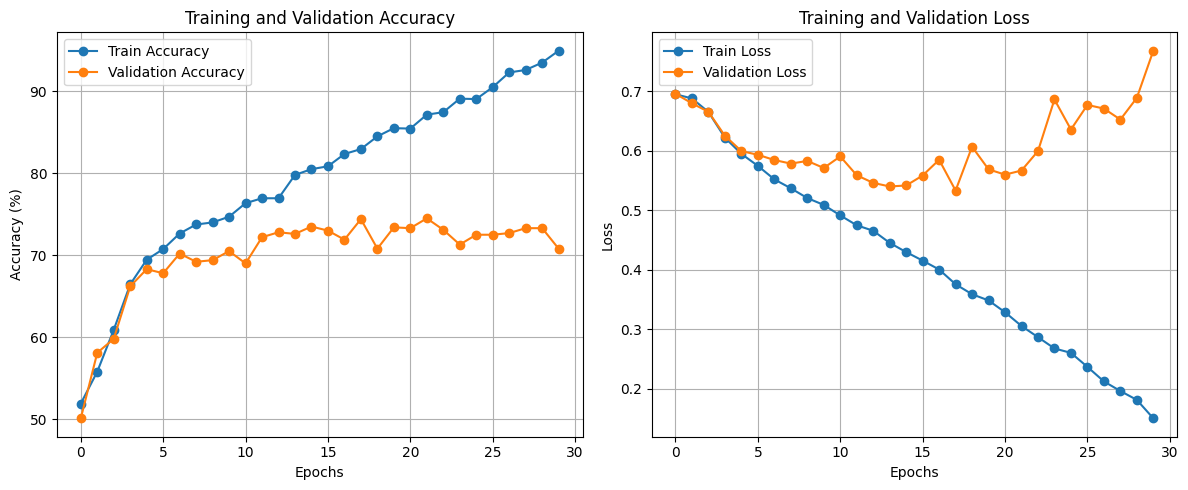

In [8]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [9]:
# Save the model
torch.save(model.state_dict(), 'dogcat_model.pth')


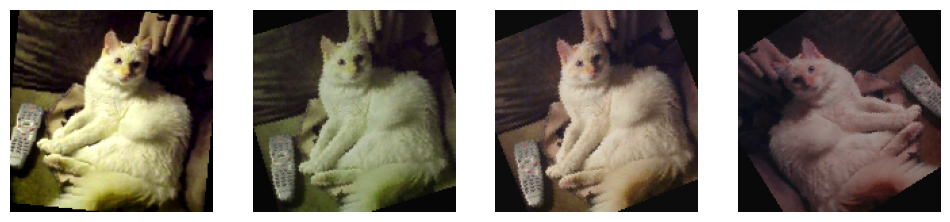

In [11]:
from PIL import Image
data_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

img_path = os.path.join(train_dir, 'cats', os.listdir(train_dir + '/cats')[3])
img = Image.open(img_path).convert("RGB")

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    augmented_image = data_transforms(img)
    img_array = augmented_image.numpy().transpose((1, 2, 0))
    axes[i].imshow(img_array)
    axes[i].axis('off')

plt.show()


In [12]:
train_transforms_aug = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=20),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

train_dataset_aug = datasets.ImageFolder(train_dir, transform=train_transforms_aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)

num_epochs_aug = 100
for epoch in range(num_epochs_aug):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, labels in train_loader_aug:
        inputs, labels = inputs.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_train = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader_aug))
    train_accuracies.append(100 * correct_train / total_train)

    print(f'Epoch [{epoch+1}/{num_epochs_aug}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%')


Epoch [1/100], Train Loss: 0.6972, Train Accuracy: 63.70%
Epoch [2/100], Train Loss: 0.6256, Train Accuracy: 65.60%
Epoch [3/100], Train Loss: 0.6175, Train Accuracy: 65.60%
Epoch [4/100], Train Loss: 0.5992, Train Accuracy: 67.25%
Epoch [5/100], Train Loss: 0.5982, Train Accuracy: 67.80%
Epoch [6/100], Train Loss: 0.5961, Train Accuracy: 67.05%
Epoch [7/100], Train Loss: 0.5875, Train Accuracy: 68.00%
Epoch [8/100], Train Loss: 0.5772, Train Accuracy: 68.65%
Epoch [9/100], Train Loss: 0.5802, Train Accuracy: 69.30%
Epoch [10/100], Train Loss: 0.5838, Train Accuracy: 69.15%
Epoch [11/100], Train Loss: 0.5829, Train Accuracy: 70.75%
Epoch [12/100], Train Loss: 0.5836, Train Accuracy: 68.70%
Epoch [13/100], Train Loss: 0.5604, Train Accuracy: 71.45%
Epoch [14/100], Train Loss: 0.5765, Train Accuracy: 69.65%
Epoch [15/100], Train Loss: 0.5666, Train Accuracy: 70.85%
Epoch [16/100], Train Loss: 0.5615, Train Accuracy: 71.60%
Epoch [17/100], Train Loss: 0.5524, Train Accuracy: 71.15%
Epoch 

In [13]:
# Save the retrained model
torch.save(model.state_dict(), 'dogcat_model_augmented.pth')


In [14]:
# Model evaluation function
def evaluate(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

train_acc = evaluate(train_loader_aug, model)
val_acc = evaluate(val_loader, model)

print(f'Train Accuracy: {train_acc:.2f}')
print(f'Validation Accuracy: {val_acc:.2f}')


Train Accuracy: 0.83
Validation Accuracy: 0.82


In [16]:
def get_predictions(loader):
    all_predictions = []
    all_labels = []
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.concatenate(all_labels), np.concatenate(all_predictions)

In [19]:
# Get predictions
train_labels, train_predictions = get_predictions(train_loader_aug)
val_labels, val_predictions = get_predictions(val_loader)

True Negatives:  385
False Positives:  115
False Negatives:  60
True Positives:  440
Total Detections:  500


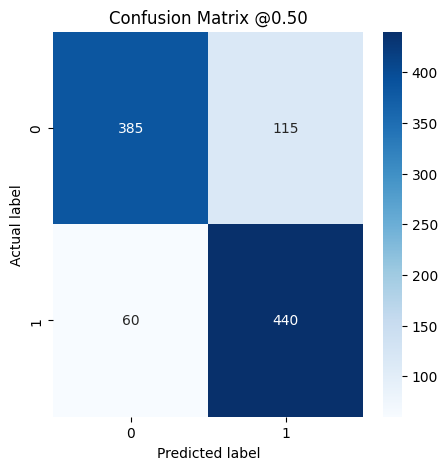

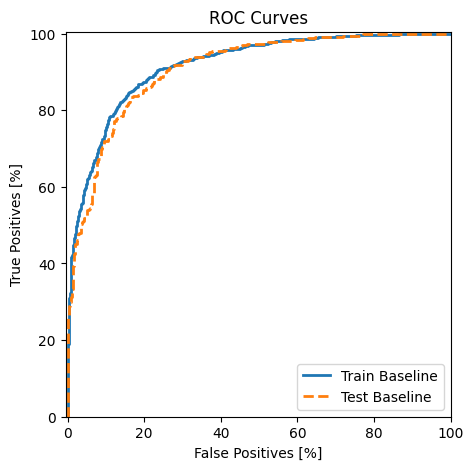

In [28]:
def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Detections: ', np.sum(cm[1]))
    
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100 * fp, 100 * tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False Positives [%]')
    plt.ylabel('True Positives [%]')
    plt.xlim([-0.5, 100])
    plt.ylim([0, 100.5])
    ax = plt.gca()
    ax.set_aspect('equal')

plot_cm(val_labels, val_predictions)

# Plot ROC Curve for Train and Validation Set
plt.figure(figsize=(5, 5))
plot_roc("Train Baseline", train_labels, train_predictions)
plot_roc("Test Baseline", val_labels, val_predictions, linestyle='--')
plt.legend(loc='lower right')
plt.title('ROC Curves')
plt.show()
